# Eris Block 1.1 Rev. A Configuration S123F -- Aerodynamic Coefficients

Storing of integrated values from OpenFOAM simulation in rhoCentralFoam:

- total pitch moment coefficient: Cm
- total drag coefficient: Cd
- total lift coefficient: Cl

| Coefficient | Description                             |
|-------------|-----------------------------------------|
| Cd          | Drag coefficient                       |
| Cs          | Side-force coefficient                 |
| Cl          | Lift coefficient                       |
| CmRoll      | Roll-moment coefficient                |
| CmPitch     | Pitch-moment coefficient               |
| CmYaw       | Yaw-moment coefficient                 |
| Cdf         | Front-axle drag coefficient            |
| Csf         | Front-axle side-force coefficient      |
| Clf         | Front-axle lift coefficient            |
| Cdr         | Rear-axle drag coefficient             |
| Csr         | Rear-axle side-force coefficient       |
| Clr         | Rear-axle lift coefficient             |

The force coefficients can also be optionally output in terms of their front and rear axle constituents:

    Cd{f,r} = 0.5*Cd {+,-} CmRoll
    Cs{f,r} = 0.5*Cs {+,-} CmYaw
    Cl{f,r} = 0.5*Cl {+,-} CmPitch

 where f and r represent front and rear axles, respectively.

Force and moment coefficients are output in their total and constituent components:

    total force and moment coefficients
    pressure contributions
    viscous contributions
    porous resistance contributions (optional)

Force and moment coefficients can be computed and output in:

    the global Cartesian coordinate system (default)
    a user-defined Cartesian coordinate system

Forces comprise normal pressure:

$$
F_p = \sum_i \rho_i \, \mathbf{s}_{f,i} \, (p_i - p_{\text{ref}})
$$

and tangential viscous contributions:

$$
F_v = \sum_i \mathbf{s}_{f,i} \cdot (\mu \mathbf{R}_{\text{dev}})
$$

Where:
- $\rho$ is the density,
- $\mathbf{s}_{f,i}$ is the face area vector,
- $p$ is the pressure,
- $\mu$ is the dynamic viscosity,
- $\mathbf{R}_{\text{dev}}$ is the deviatoric stress tensor.

https://www.openfoam.com/documentation/guides/latest/api/classFoam_1_1functionObjects_1_1forceCoeffs.html#details

In [45]:
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import subprocess
import sys
import warnings

plt.rcParams.update({'font.size': 22})
warnings.filterwarnings('ignore')

In [46]:
# Get the current working directory
current_path = os.getcwd()
print(f"Current path saved: {current_path}")

Current path saved: /home/lorenzo/CFD/ERIS/POSTPROCESSING


# Load old AERO results

In [47]:
# Path to the JSON file
file_path = "./Eris_B1_1_Aerodynamics.json"

# Load the JSON data
with open(file_path, 'r') as file:
    data = json.load(file)

# Access the main sections
aerodynamics_data = data.get("Aerodynamics", {})

# Accessing specific phases
phase_123F = aerodynamics_data.get("Phase 123F", {})
phase_23F = aerodynamics_data.get("Phase 23F", {})
uncertainty_scale_error = aerodynamics_data.get("Uncertainty Scale Error", {})

# Print some information
print("Phase 123F Reference Area:", phase_123F.get("Reference Area"))
print("Phase 23F Reference Length:", phase_23F.get("Reference Length"))

# Iterating over the aerodynamic coefficient map for Phase 123F
coefficient_map = phase_123F.get("Aerodynamic Coefficient Map", [])
for entry in coefficient_map:
    print(f"Mach: {entry['Mach']}, CA: {entry['CA']}, CN Alpha: {entry['CN Alpha']}")

Phase 123F Reference Area: 3.1416
Phase 23F Reference Length: 1.5
Mach: 0.5, CA: 0.20605402, CN Alpha: 0.046410367
Mach: 0.806, CA: 0.21543269, CN Alpha: 0.43932986
Mach: 0.998, CA: 0.4886865, CN Alpha: 0.51165371
Mach: 1.291, CA: 0.52867007, CN Alpha: 0.44838153
Mach: 1.725, CA: 0.46545768, CN Alpha: 0.46666887
Mach: 2.52, CA: 0.35781094, CN Alpha: 0.49730074
Mach: 3.48, CA: 0.28799617, CN Alpha: 0.05001773
Mach: 4.507, CA: 0.24025521, CN Alpha: 0.051180335
Mach: 5.69, CA: 0.1929, CN Alpha: 0.0397
Mach: 6.0, CA: 0.1849, CN Alpha: 0.0395
Mach: 7.0, CA: 0.1667, CN Alpha: 0.0395


In [48]:
# Make it dataframe
df_coefficient_map = pd.DataFrame(coefficient_map)
df_coefficient_map

,Mach,CA,CN Alpha,CM Alpha,CMAD,CMQ,CNAD,CNQ
0,0.500,0.206054,0.046410,-0.206955,-2.2863,-3.1238,0.5853,0.8204
1,0.806,0.215433,0.439330,-0.186681,-2.8215,-3.8571,0.5856,0.8210
2,0.998,0.488687,0.511654,-0.198690,-3.3072,-4.5790,0.5930,0.8375
3,1.291,0.528670,0.448382,-0.143315,-4.1833,-5.8172,0.6641,0.9403
4,1.725,0.465458,0.466669,-0.133836,-5.2959,-9.5599,0.8407,1.3967
5,2.520,0.357811,0.497301,-0.155564,-4.6975,-7.5671,0.7457,1.1531
6,3.480,0.287996,0.050018,-0.160225,-3.9631,-5.6210,0.6291,0.9011
7,4.507,0.240255,0.051180,-0.175746,-3.7400,-5.4052,0.5937,0.8599
8,5.690,0.192900,0.039700,-0.132100,-3.6608,-5.3299,0.5811,0.8453
9,6.000,0.184900,0.039500,-0.132400,-3.6309,-5.3157,0.5764,0.8412


# Load DATCOM results

Here I just want to check that the results of DATCOM obtained with different flight conditions (FLTCON) are reasonably similar.

In [49]:
datcom  = pd.read_csv("../DATCOM/MACH_ALPHA_CA_CN_CM.csv")
datcom0 = datcom[datcom['ALPHA']==0.0]
datcom4 = datcom[datcom['ALPHA']==4.0]
datcom

,MACH,ALPHA,CA,CN,CM
0,0.60,0.0,0.2164,0.0000,0.0000
1,0.60,2.0,0.2163,0.0771,-0.2351
2,0.60,4.0,0.2152,0.1690,-0.5586
3,0.60,6.0,0.2130,0.2760,-0.9730
4,0.90,0.0,0.3454,0.0000,0.0000
5,0.90,2.0,0.3454,0.0772,-0.2357
6,0.90,4.0,0.3447,0.1697,-0.5624
7,0.90,6.0,0.3434,0.2780,-0.9847
8,0.99,0.0,0.4770,0.0000,0.0000
9,0.99,2.0,0.4768,0.0785,-0.2434


# Load OpenFOAM results

In [50]:
root         = "../SIMULATIONS/"
flight_times = ["t34s","t43s","t46s","t49s","t61s","t107s"]
solvers_name = ["rhoCentralFoam"]
grid_levels  = ["R0","R1","R2"]
angle_values = [0.0, 4.0]
file_path    = "postProcessing/forceCoeffs1/" 
file_name    = "coefficient.dat"

In [51]:
# Dictionary to store DataFrames for each flight time
data_dict = {}
result = pd.DataFrame()

# Mapping of flight times to Mach numbers
# Not the most elegant solution: should be read from t*.csv
mach_mapping = {
    "34": 0.6, "43": 0.9, "46": 0.99, "49": 1.10, "61": 1.67, "107": 4.51
}
        
# Helper function to execute post-processing steps
def execute_postprocess(pp_path, solver):
    try:
        os.chdir(pp_path)
        if solver == "rhoCentralFoam":
            os.system("rhoCentralFoam -postProcess -latestTime > /dev/null 2>&1")
        elif solver == "rhoPimpleFoam":
            os.system("rhoPimpleFoam -postProcess -latestTime > /dev/null 2>&1")
        os.chdir(current_path)
    except Exception as e:
        print(f"Error: {e} for solver {solver}")
        os.chdir(current_path)
        return

# Helper function to clean-up previous post-processing
def remove_postprocess(pp_path):
    try:
        # Try changing the directory to pp_path and remove postProcessing folder if it exists
        os.chdir(pp_path)
        subprocess.run(["rm", "-r", "postProcessing"], check=True)  # Remove postProcessing
        os.chdir(current_path)  # Return to the original directory
    except Exception as e:
        print(f"Error: {e} while removing postProcessing.")
        os.chdir(current_path)  # Ensure we're back in the original directory
        return
        
# Process each flight time
for time in flight_times:
    print(f"Flight time: {time}")
    for solver in solvers_name:
        print(f"   Solver: {solver}")
        for grid in grid_levels:
            print(f"      Grid level: {grid}")
            for angle in angle_values:
                print(f"         Angle of attack: {angle}")
                
                pp_path = os.path.join(root, time, solver, grid, f"angle_{angle}")
                remove_postprocess(pp_path)
                execute_postprocess(pp_path, solver)
                
                # Construct directory path
                dir_path = os.path.join(root, time, solver, grid, f"angle_{angle}", file_path)
                try:
                    os.chdir(dir_path)
                except:
                    pass
                
                # Get the latest time directory
                try:
                    latest_time = !foamListTimes -latestTime -withZero | tail -n 1
                    latest_time = latest_time[0] + "/"
                    os.chdir(current_path)
                except:
                    print("Error fetching latest time.")
                    os.chdir(current_path)
                    continue
    
                # Construct full file path
                file = os.path.join(root, time, solver, grid, f"angle_{angle}", file_path, latest_time, file_name)
                print(f"File path: {file}")
                
                # Read data and create DataFrame
                data = np.genfromtxt(file)
                df = pd.DataFrame([data], columns=['Time', 'Cd', 'Cd(f)', 'Cd(r)', 'Cl', 'Cl(f)', 'Cl(r)', 'CmPitch', 'CmRoll', 'CmYaw', 'Cs', 'Cs(f)', 'Cs(r)'])
                
                # Add additional columns
                df['AoA'] = angle
                df['Solver'] = solver
                df.rename(columns={'Time': 'LastIter'}, inplace=True)
                df['Time'] = time[1:-1]
                df['GridLevel'] = grid
                df['Mach'] = df['Time'].map(mach_mapping)
                
                # Store DataFrame in the dictionary and concatenate to the result
                data_dict[time] = df
                result = pd.concat([result, df], ignore_index=True)

Flight time: t34s
   Solver: rhoCentralFoam
      Grid level: R0
         Angle of attack: 0.0
File path: ../SIMULATIONS/t34s/rhoCentralFoam/R0/angle_0.0/postProcessing/forceCoeffs1/8226/coefficient.dat
         Angle of attack: 4.0
File path: ../SIMULATIONS/t34s/rhoCentralFoam/R0/angle_4.0/postProcessing/forceCoeffs1/13582/coefficient.dat
      Grid level: R1
         Angle of attack: 0.0
File path: ../SIMULATIONS/t34s/rhoCentralFoam/R1/angle_0.0/postProcessing/forceCoeffs1/14656/coefficient.dat
         Angle of attack: 4.0
File path: ../SIMULATIONS/t34s/rhoCentralFoam/R1/angle_4.0/postProcessing/forceCoeffs1/14155/coefficient.dat
      Grid level: R2
         Angle of attack: 0.0
File path: ../SIMULATIONS/t34s/rhoCentralFoam/R2/angle_0.0/postProcessing/forceCoeffs1/252958/coefficient.dat
         Angle of attack: 4.0
File path: ../SIMULATIONS/t34s/rhoCentralFoam/R2/angle_4.0/postProcessing/forceCoeffs1/148400/coefficient.dat
Flight time: t43s
   Solver: rhoCentralFoam
      Grid lev

rm: cannot remove 'postProcessing': No such file or directory


Error fetching latest time.
         Angle of attack: 4.0
Error: Command '['rm', '-r', 'postProcessing']' returned non-zero exit status 1. while removing postProcessing.


rm: cannot remove 'postProcessing': No such file or directory


Error fetching latest time.


In [52]:
result

,LastIter,Cd,Cd(f),Cd(r),Cl,Cl(f),Cl(r),CmPitch,CmRoll,CmYaw,Cs,Cs(f),Cs(r),AoA,Solver,Time,GridLevel,Mach
0,8226.0,0.313397,0.156485,0.156911,8.010735e-04,0.001675,-0.000874,0.001275,-2.130082e-04,1.517957,-0.293912,1.371001,-1.664914,0.0,rhoCentralFoam,34,R0,0.60
1,13582.0,0.315914,0.159402,0.156512,-1.916655e-01,-1.173134,0.981468,-1.077301,1.444726e-03,1.644905,-0.330167,1.479822,-1.809989,4.0,rhoCentralFoam,34,R0,0.60
2,14656.0,0.302559,0.150589,0.151970,-1.261613e-03,0.001786,-0.003048,0.002417,-6.905603e-04,1.552663,-0.352678,1.376324,-1.729003,0.0,rhoCentralFoam,34,R1,0.60
3,14155.0,0.302447,0.152065,0.150382,-1.875704e-01,-1.143181,0.955611,-1.049396,8.416444e-04,1.905480,-0.422629,1.694166,-2.116795,4.0,rhoCentralFoam,34,R1,0.60
4,252958.0,0.309897,0.154648,0.155249,-2.099756e-03,-0.001759,-0.000341,-0.000709,-3.002726e-04,1.461323,-0.359073,1.281787,-1.640859,0.0,rhoCentralFoam,34,R2,0.60
5,148400.0,0.324272,0.168665,0.155607,-1.895193e-01,-1.190502,1.000982,-1.095742,6.529048e-03,1.559651,-0.448163,1.335570,-1.783732,4.0,rhoCentralFoam,34,R2,0.60
6,22362.0,0.316178,0.158008,0.158170,7.090190e-04,0.001483,-0.000774,0.001129,-8.057354e-05,1.778321,-0.341742,1.607450,-1.949192,0.0,rhoCentralFoam,43,R0,0.90
7,12474.0,0.324716,0.163999,0.160718,-1.716480e-01,-1.083286,0.911638,-0.997462,1.640654e-03,1.868410,-0.387407,1.674707,-2.062113,4.0,rhoCentralFoam,43,R0,0.90
8,15896.0,0.322557,0.161292,0.161265,-4.880946e-04,0.001555,-0.002043,0.001799,1.345440e-05,1.526560,-0.342990,1.355065,-1.698055,0.0,rhoCentralFoam,43,R1,0.90
9,16141.0,0.325859,0.164570,0.161289,-1.694830e-01,-1.060768,0.891285,-0.976026,1.640325e-03,1.881269,-0.413680,1.674429,-2.088109,4.0,rhoCentralFoam,43,R1,0.90


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[0. 4.]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Plot saved as rhoCentralFoam_CA_CN_CM.eps


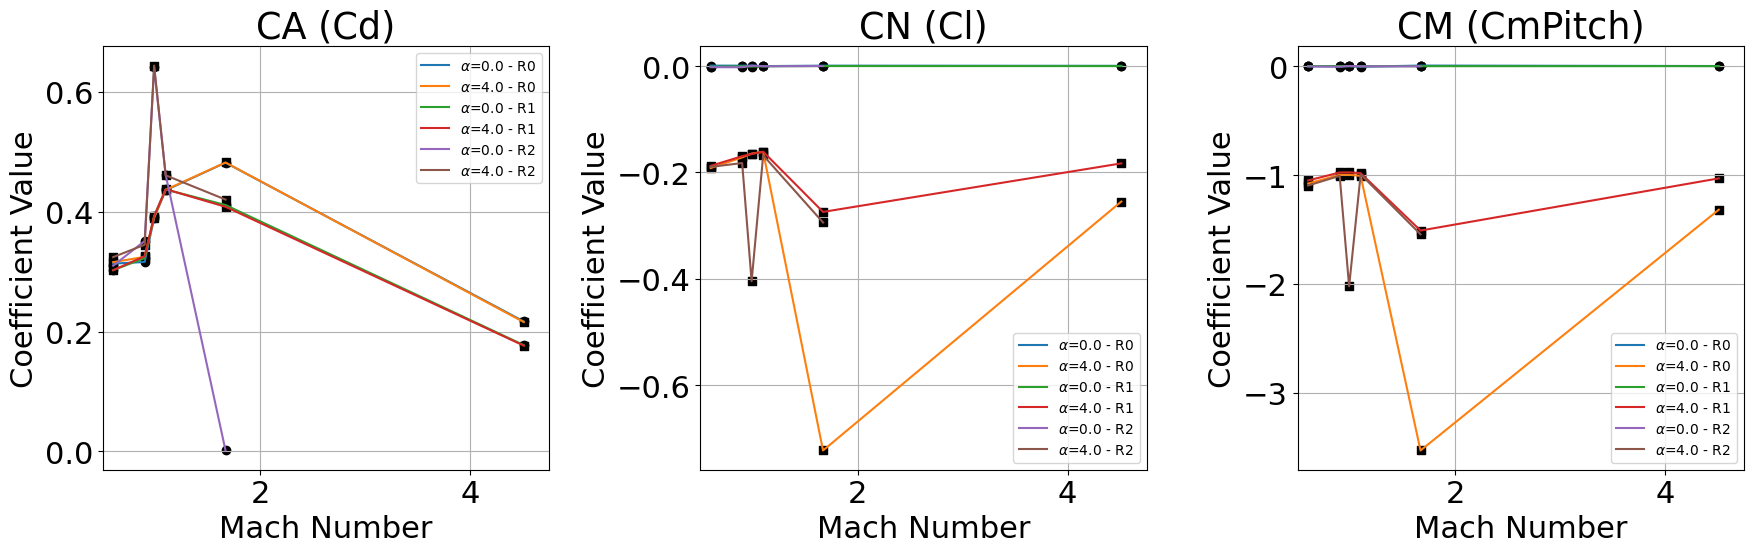

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Plot saved as rhoCentralFoam_CA_CN_CM.eps


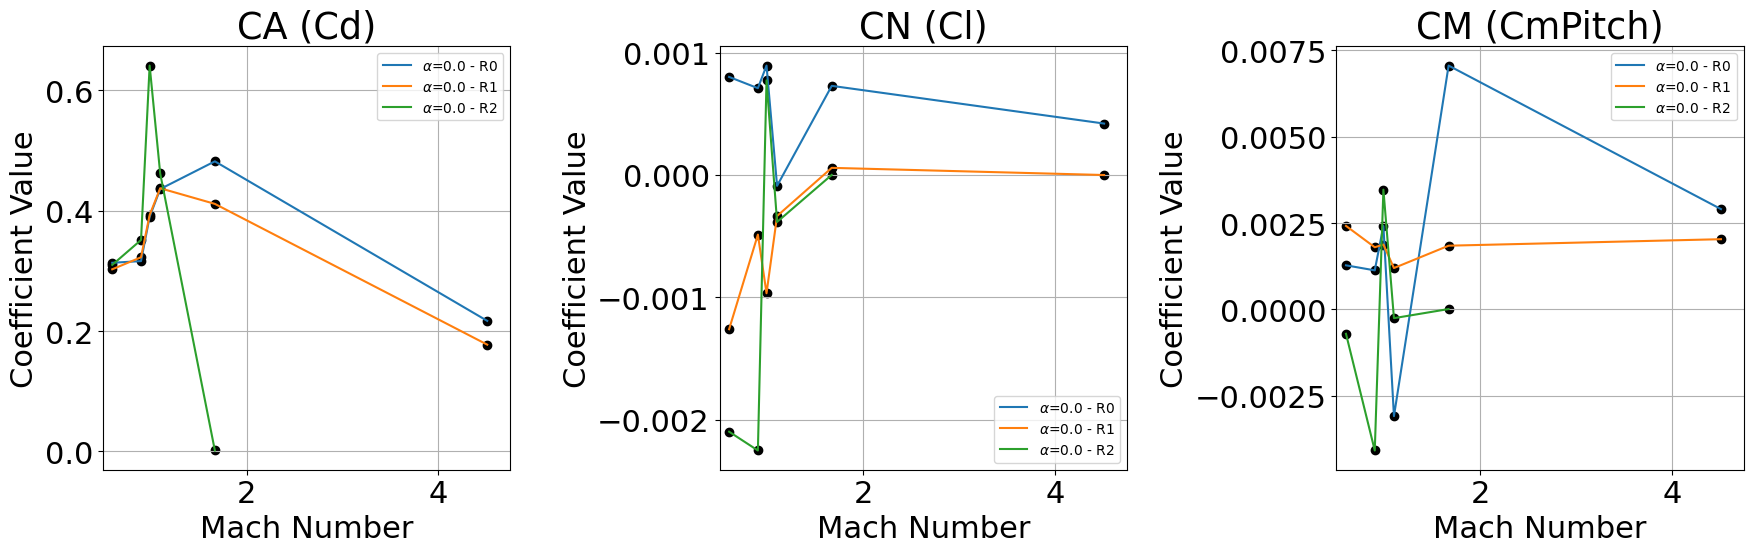

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Plot saved as rhoCentralFoam_CA_CN_CM.eps


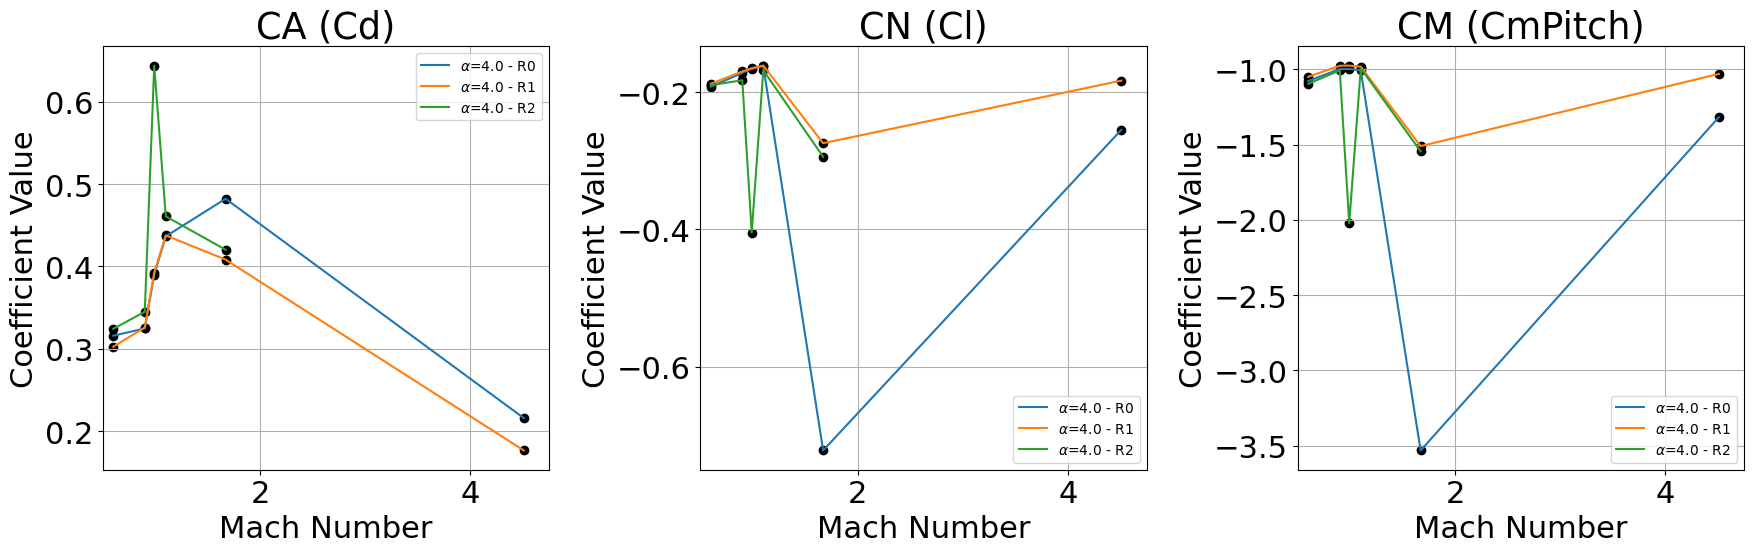

In [138]:
# Define the list of solvers and grid levels
solvers = result['Solver'].unique()
grid_levels = ['R0', 'R1', 'R2']

# Create a function to plot CA, CN, and CM
def plot_solution(df, solver, alpha_values):
    if isinstance(alpha_values, (np.float64, float, int)):
        alpha_values = [alpha_values]  # Convert single value to a list
    
    # Define marker styles for different alpha values
    markers = ['o', 's', '^', 'D', 'p', '*', 'X', '+', 'H']  # Add as many markers as needed
    marker_dict = {alpha: markers[i % len(markers)] for i, alpha in enumerate(alpha_values)}
    
    # Initialize subplots for CA, CN, and CM in a single row
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns
    
    # Loop over each grid level and plot all data in the same plot
    for grid_level in grid_levels:
        # Filter data for the given solver and grid level
        filtered_df = df[(df['Solver'] == solver) & (df['GridLevel'] == grid_level)]
        
        if filtered_df.empty:
            print(f"No solution for Solver: {solver}, Grid Level: {grid_level}")
            continue
        
        # Plot data for each angle of attack (AoA)
        for alpha in alpha_values:
            # Filter data for the given angle of attack
            alpha_df = filtered_df[filtered_df['AoA'] == alpha]
            
            if alpha_df.empty:
                print(f"No data for AoA: {alpha} in Solver: {solver}, Grid Level: {grid_level}")
                continue
            
            # Plot CA (Cd), CN (Cl), CM (CmPitch) for the current grid level and AoA
            axes[0].plot(alpha_df['Mach'], alpha_df['Cd'], label=r'$\alpha$=' f'{alpha} - {grid_level}')
            axes[1].plot(alpha_df['Mach'], alpha_df['Cl'], label=r'$\alpha$=' f'{alpha} - {grid_level}')
            axes[2].plot(alpha_df['Mach'], alpha_df['CmPitch'], label=r'$\alpha$=' f'{alpha} - {grid_level}')
            
            # Add scatter points for each data point
            axes[0].scatter(alpha_df['Mach'], alpha_df['Cd'], color='black', marker=marker_dict[alpha])
            axes[1].scatter(alpha_df['Mach'], alpha_df['Cl'], color='black', marker=marker_dict[alpha])
            axes[2].scatter(alpha_df['Mach'], alpha_df['CmPitch'], color='black', marker=marker_dict[alpha])

            # Set labels and titles
            axes[0].set_title(f"CA (Cd)")
            axes[1].set_title(f"CN (Cl)")
            axes[2].set_title(f"CM (CmPitch)")
        
            for ax in axes:
                ax.set_xlim(0.5,4.75)
                ax.set_xlabel("Mach Number")
                ax.set_ylabel("Coefficient Value")
                ax.legend(loc='best', fontsize=10)
                ax.grid(True)

            plt.tight_layout()

            plt.savefig(f"{solver}_alpha_{alpha}_CA_CN_CM.eps", format="eps")    

    # Save the plots as EPS files
    plt.savefig(f"{solver}_CA_CN_CM.eps", format="eps")
    print(f"Plot saved as {solver}_CA_CN_CM.eps")
    
    plt.show()
    plt.close()

# Define list of unique AoA values from the dataframe
alpha_values = result['AoA'].unique()
print(alpha_values)

# Loop through each solver and plot for all grid levels
for solver in solvers:
    plot_solution(result, solver, alpha_values)
    plot_solution(result, solver, alpha_values[0])
    plot_solution(result, solver, alpha_values[1])
    #plot_solution(result, solver, alpha_values[2])

In [139]:
result0 = result[result["AoA"] == 0]
result4 = result[result["AoA"] == 4]

In [140]:
rhoCentralFoam    = result0[result0["Solver"] == "rhoCentralFoam"]
rhoPimpleFoam     = result0[result0["Solver"] == "rhoPimpleFoam"]

rhoCentralFoam_R0 = result0[(result0["Solver"] == "rhoCentralFoam") & (result0["GridLevel"] == "R0")]
rhoPimpleFoam_R0  = result0[(result0["Solver"] == "rhoPimpleFoam")  & (result0["GridLevel"] == "R0")]

rhoCentralFoam_R1 = result0[(result0["Solver"] == "rhoCentralFoam") & (result0["GridLevel"] == "R1")]
rhoPimpleFoam_R1  = result0[(result0["Solver"] == "rhoPimpleFoam")  & (result0["GridLevel"] == "R1")]

rhoCentralFoam_R2 = result0[(result0["Solver"] == "rhoCentralFoam") & (result0["GridLevel"] == "R2")]
rhoPimpleFoam_R2  = result0[(result0["Solver"] == "rhoPimpleFoam")  & (result0["GridLevel"] == "R2")]

rhoCentralFoam_R3 = result0[(result0["Solver"] == "rhoCentralFoam") & (result0["GridLevel"] == "R3")]
rhoPimpleFoam_R3  = result0[(result0["Solver"] == "rhoPimpleFoam")  & (result0["GridLevel"] == "R3")]

In [141]:
# Define the grid level (change this to "R0", "R1", "R2", or "R3" to select the dataset)
# From the figures above we can see the trends across different grid levels
# Typically we would select the finest grid level available, R2 for example
grid_level = "R1" 

# Assuming rhoCentralFoam datasets are dictionaries or DataFrames
# Select the corresponding dataset based on the grid level
# TODO: improve to handle evental rhoPimpleFoam solutions
if grid_level == "R0":
    dataset = rhoCentralFoam_R0
elif grid_level == "R1":
    dataset = rhoCentralFoam_R1
elif grid_level == "R2":
    dataset = rhoCentralFoam_R2
elif grid_level == "R3":
    dataset = rhoCentralFoam_R3
else:
    raise ValueError("Invalid grid level. Please choose from 'R0', 'R1', 'R2', or 'R3'.")
dataset

,LastIter,Cd,Cd(f),Cd(r),Cl,Cl(f),Cl(r),CmPitch,CmRoll,CmYaw,Cs,Cs(f),Cs(r),AoA,Solver,Time,GridLevel,Mach
2,14656.0,0.302559,0.150589,0.151970,-1.261613e-03,0.001786,-0.003048,0.002417,-0.000691,1.552663,-0.352678,1.376324,-1.729003,0.0,rhoCentralFoam,34,R1,0.60
8,15896.0,0.322557,0.161292,0.161265,-4.880946e-04,0.001555,-0.002043,0.001799,0.000013,1.526560,-0.342990,1.355065,-1.698055,0.0,rhoCentralFoam,43,R1,0.90
14,23960.0,0.392739,0.196299,0.196440,-9.675582e-04,0.001394,-0.002361,0.001877,-0.000070,1.697907,-0.304270,1.545772,-1.850043,0.0,rhoCentralFoam,46,R1,0.99
20,13885.0,0.437251,0.217474,0.219777,-3.360364e-04,0.001028,-0.001364,0.001196,-0.001152,1.192385,-0.202704,1.091033,-1.293737,0.0,rhoCentralFoam,49,R1,1.10
26,100000.0,0.411262,0.204971,0.206291,5.771693e-05,0.001873,-0.001815,0.001844,-0.000660,-0.894155,0.084397,-0.851957,0.936354,0.0,rhoCentralFoam,61,R1,1.67
32,300000.0,0.177350,0.088569,0.088781,-8.762325e-07,0.002031,-0.002032,0.002032,-0.000106,-1.267362,0.158561,-1.188082,1.346643,0.0,rhoCentralFoam,107,R1,4.51


In [142]:
yshift           = 0.0
cn               = dataset["Cl"] 
upper_margin     = cn * 1.20 
lower_margin     = cn * 0.80  
variable_margins = np.full(len(cn), 0.20)
error            = cn * variable_margins 
error            = np.abs(error)        

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


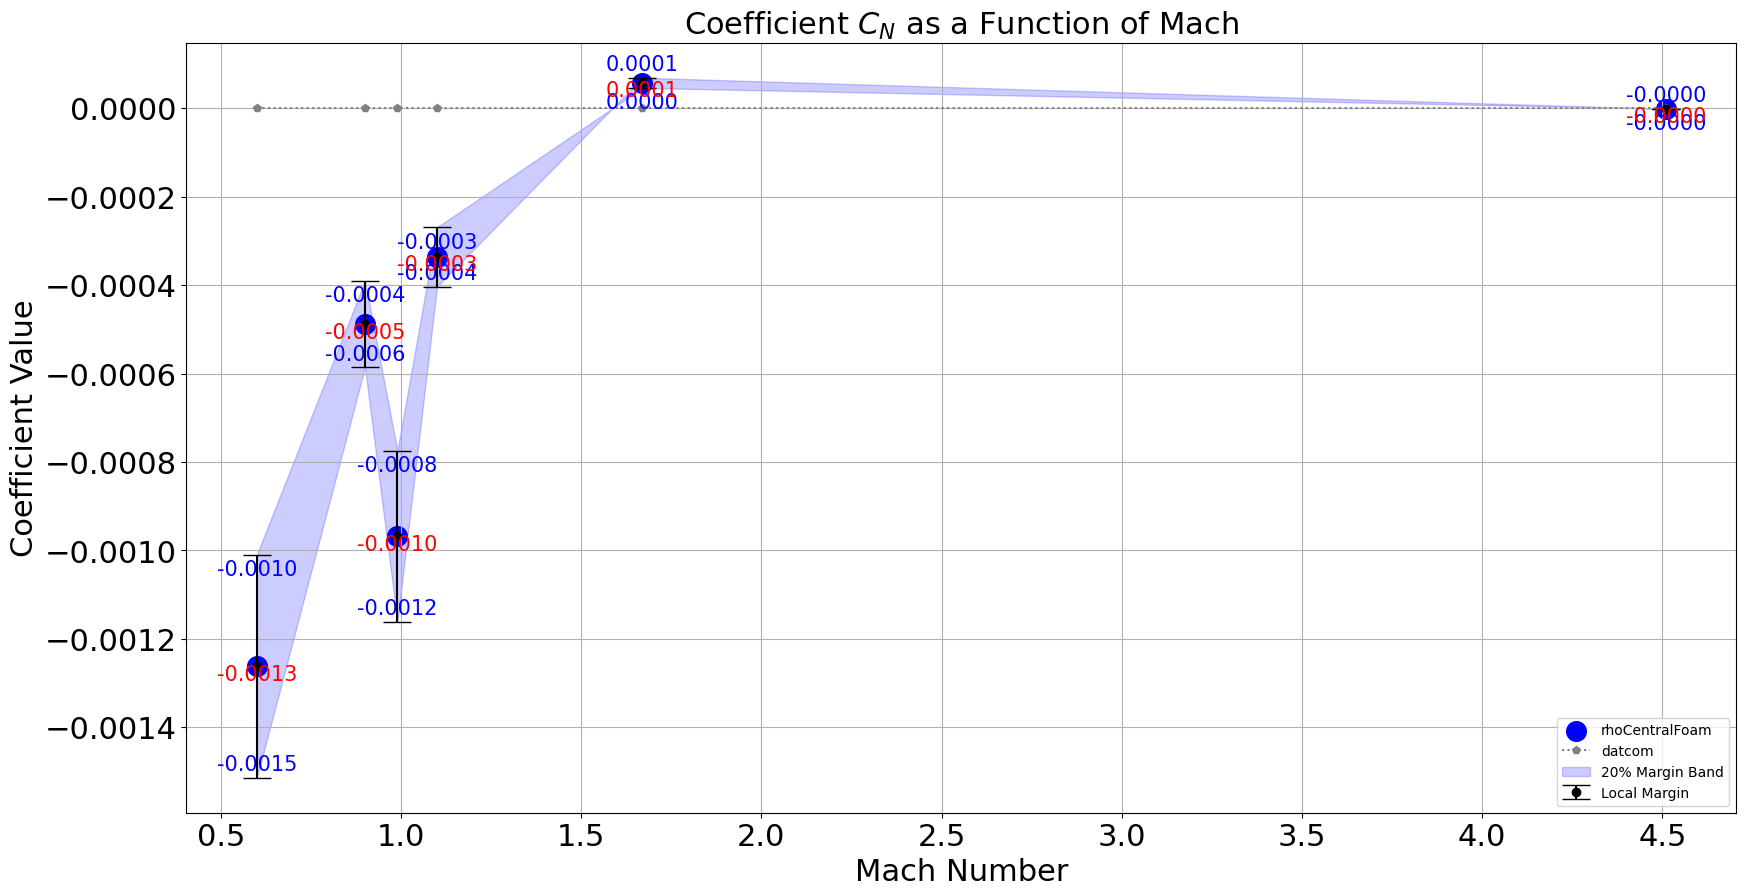

In [143]:
plt.figure(figsize=(20, 10))

plt.scatter(dataset["Mach"], cn, label=r'rhoCentralFoam', s=200, marker='o', color='b', linestyle='solid')

#plt.scatter(rhoCentralFoam_R0["Mach"], rhoCentralFoam_R0["Cl"], label='CN rhoCentralFoam R0', s=200, marker='o', color='b', linestyle='solid')
#plt.scatter(rhoCentralFoam_R1["Mach"], rhoCentralFoam_R1["Cl"], label='CN rhoCentralFoam R1', s=200, marker='s', color='b', linestyle='dashed')
#plt.scatter(rhoCentralFoam_R2["Mach"], rhoCentralFoam_R2["Cl"], label='CN rhoCentralFoam R2', s=200, marker='X', color='b', linestyle='dashdot')
#plt.scatter(rhoCentralFoam_R3["Mach"], rhoCentralFoam_R3["Cl"], label=f'$C_N$ rhoCentralFoam $R_3$', s=200, marker='p', color='b', linestyle='dotted')
#plt.scatter(rhoPimpleFoam_R3["Mach"],  rhoPimpleFoam_R3["Cl"],  label=f'$C_N$ rhoPimpleFoam $R_3$', s=200, marker='^', color='b', linestyle='dotted')

plt.plot(datcom0["MACH"], -datcom0["CN"]+yshift, label=r'datcom', marker='p', linestyle=':', color='gray')

# Add a 20% margin band
plt.fill_between(dataset["Mach"], lower_margin, upper_margin, color='blue', alpha=0.2, label='20% Margin Band')

# Add vertical bars and annotations for each point
plt.errorbar(dataset["Mach"], cn, yerr=error, fmt='o', color='k', capsize=10, label='Local Margin')

# Annotate each margin value above each point
for i, margin in enumerate(variable_margins):

    # Annotate upper and lower margins near the error bar
    plt.annotate(f"{upper_margin.iloc[i]:.4f}", 
                 (dataset["Mach"].iloc[i], upper_margin.iloc[i]), 
                 textcoords="offset points", xytext=(0, 5),
                 ha='center', fontsize=15, color='blue')
    
    plt.annotate(f"{lower_margin.iloc[i]:.4f}", 
                 (dataset["Mach"].iloc[i], lower_margin.iloc[i]), 
                 textcoords="offset points", xytext=(0, -15),
                 ha='center', fontsize=15, color='blue')

   # Annotate the actual value at each data point
    plt.annotate(f"{cn.iloc[i]:.4f}", 
                 (dataset["Mach"].iloc[i], cn.iloc[i]), 
                 textcoords="offset points", xytext=(0, -10),
                 ha='center', fontsize=15, color='red')
#plt.xlim(0,5)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(fontsize=22)
plt.xlabel('Mach Number')
plt.ylabel('Coefficient Value')
plt.title(r'Coefficient $C_N$ as a Function of Mach', fontsize=22)
plt.legend(fontsize=10)
plt.grid(True)
file_formats = ["pdf", "eps", "png"]
for fmt in file_formats:
    plt.savefig(f"Eris0_CN.{fmt}")
plt.show()
plt.close()

In [144]:
yshift           = 0.0
cd               = dataset["Cd"]
upper_margin     = cd * 1.20 
lower_margin     = cd * 0.80 
variable_margins = np.full(len(cd), 0.20)
error            = cd * variable_margins
error            = np.abs(cd * variable_margins) 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


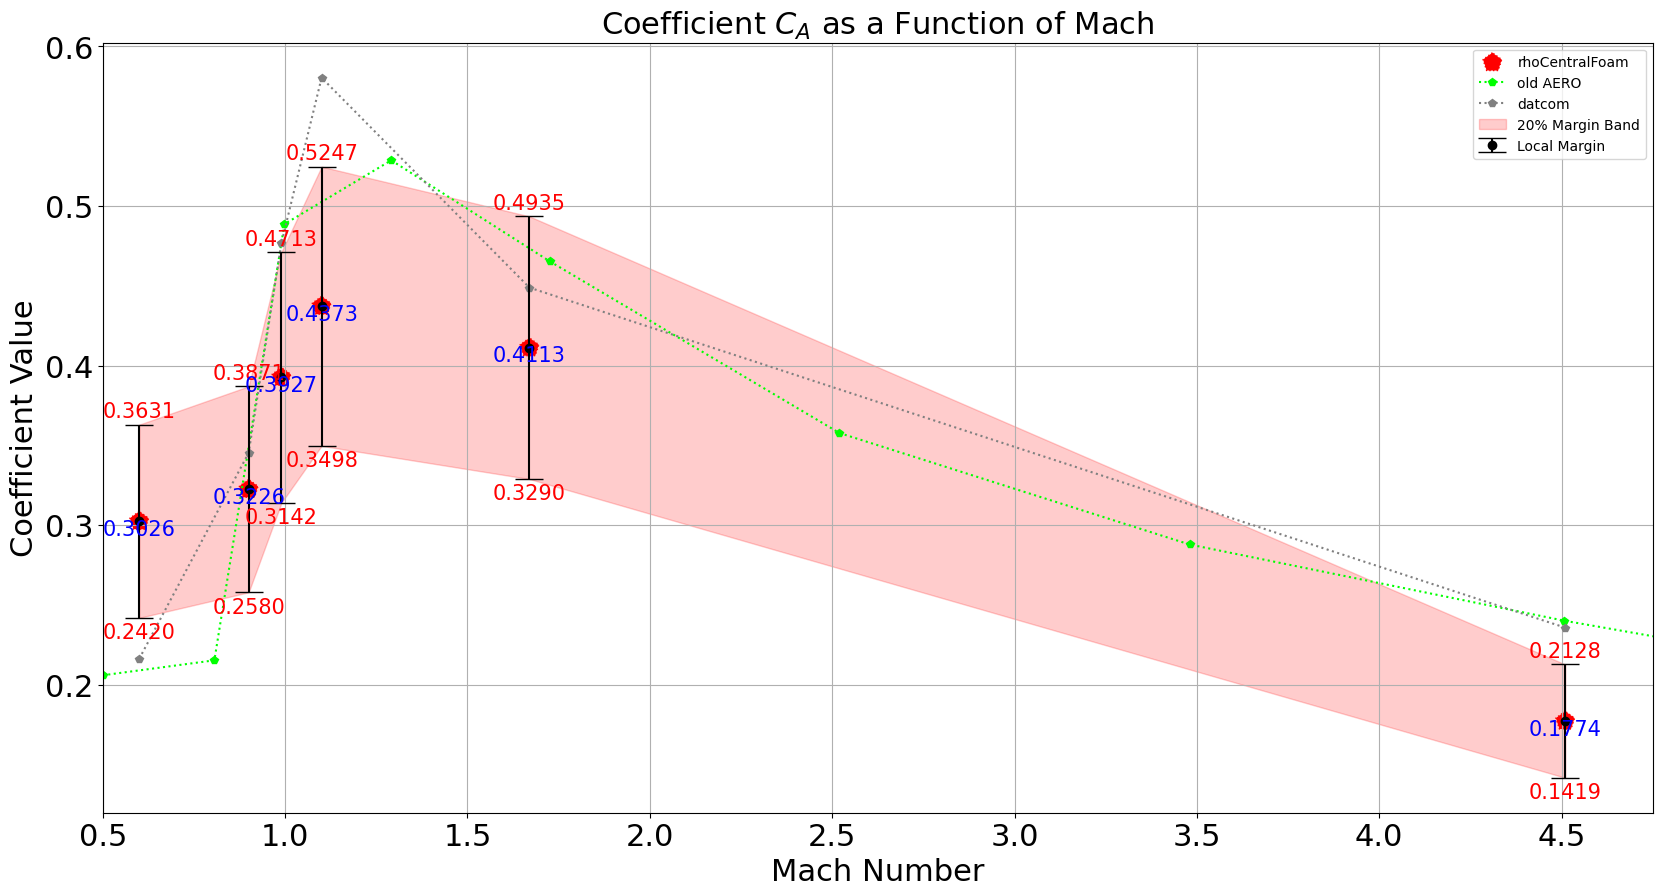

In [147]:
plt.figure(figsize=(20, 10))

plt.scatter(dataset["Mach"], dataset["Cd"], label=f'rhoCentralFoam', s=200, marker='p', color='r', linestyle='dotted')

#plt.scatter(rhoCentralFoam_R0["Mach"], rhoCentralFoam_R0["Cd"], label='CA rhoCentralFoam R0', s=200, marker='o', color='r', linestyle='solid')
#plt.scatter(rhoCentralFoam_R1["Mach"], rhoCentralFoam_R1["Cd"], label='CA rhoCentralFoam R1', s=200, marker='s', color='r', linestyle='dashed')
#plt.scatter(rhoCentralFoam_R2["Mach"], rhoCentralFoam_R2["Cd"], label='CA rhoCentralFoam R2', s=200, marker='X', color='r', linestyle='dashdot')
#plt.scatter(rhoCentralFoam_R3["Mach"], rhoCentralFoam_R3["Cd"], label=f'$C_A$ rhoCentralFoam $R_3$', s=200, marker='p', color='r', linestyle='dotted')
#plt.scatter(rhoPimpleFoam_R3["Mach"],  rhoPimpleFoam_R3["Cd"],  label=f'$C_A$ rhoPimpleFoam $R_3$', s=200, marker='^', color='b', linestyle='dotted')

# Old AERO results
plt.plot(df_coefficient_map["Mach"], df_coefficient_map["CA"], label='old AERO', marker='p', linestyle=':', color='lime')

plt.plot(datcom0["MACH"], datcom0["CA"]+yshift, label='datcom', marker='p', linestyle=':', color='gray')

# Add a 20% margin band 
plt.fill_between(dataset["Mach"], lower_margin, upper_margin, color='red', alpha=0.2, label='20% Margin Band')

# Add vertical bars and annotations for each point
plt.errorbar(dataset["Mach"], cd, yerr=error, fmt='o', color='k', capsize=10, label='Local Margin')

# Annotate each margin value above each point
for i, margin in enumerate(variable_margins):

    # Annotate upper and lower margins near the error bar
    plt.annotate(f"{upper_margin.iloc[i]:.4f}", 
                 (dataset["Mach"].iloc[i], upper_margin.iloc[i]), 
                 textcoords="offset points", xytext=(0, 5),
                 ha='center', fontsize=15, color='red')
    
    plt.annotate(f"{lower_margin.iloc[i]:.4f}", 
                 (dataset["Mach"].iloc[i], lower_margin.iloc[i]), 
                 textcoords="offset points", xytext=(0, -15),
                 ha='center', fontsize=15, color='red')

   # Annotate the actual value at each data point
    plt.annotate(f"{cd.iloc[i]:.4f}", 
                 (dataset["Mach"].iloc[i], cd.iloc[i]), 
                 textcoords="offset points", xytext=(0, -10),
                 ha='center', fontsize=15, color='blue')
plt.xlim(0.5,4.75)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(fontsize=22)
plt.xlabel('Mach Number')
plt.ylabel('Coefficient Value')
plt.title(r'Coefficient $C_A$ as a Function of Mach', fontsize=22)
plt.legend(fontsize=10)
plt.grid(True)
file_formats = ["pdf", "eps", "png"]
for fmt in file_formats:
    plt.savefig(f"Eris0_CA.{fmt}")
plt.show()
plt.close()

In [148]:
yshift           = 0.0
cm_pitch         = dataset["CmPitch"]
upper_margin     = cm_pitch * 1.20  
lower_margin     = cm_pitch * 0.80 
variable_margins = np.full(len(cm_pitch), 0.20)
error            = cm_pitch * variable_margins
error            = np.abs(cm_pitch * variable_margins) 

In [149]:
# Option to control whether annotations are displayed
show_annotations = True  
annotate_means   = True   
annotate_bounds  = False  

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


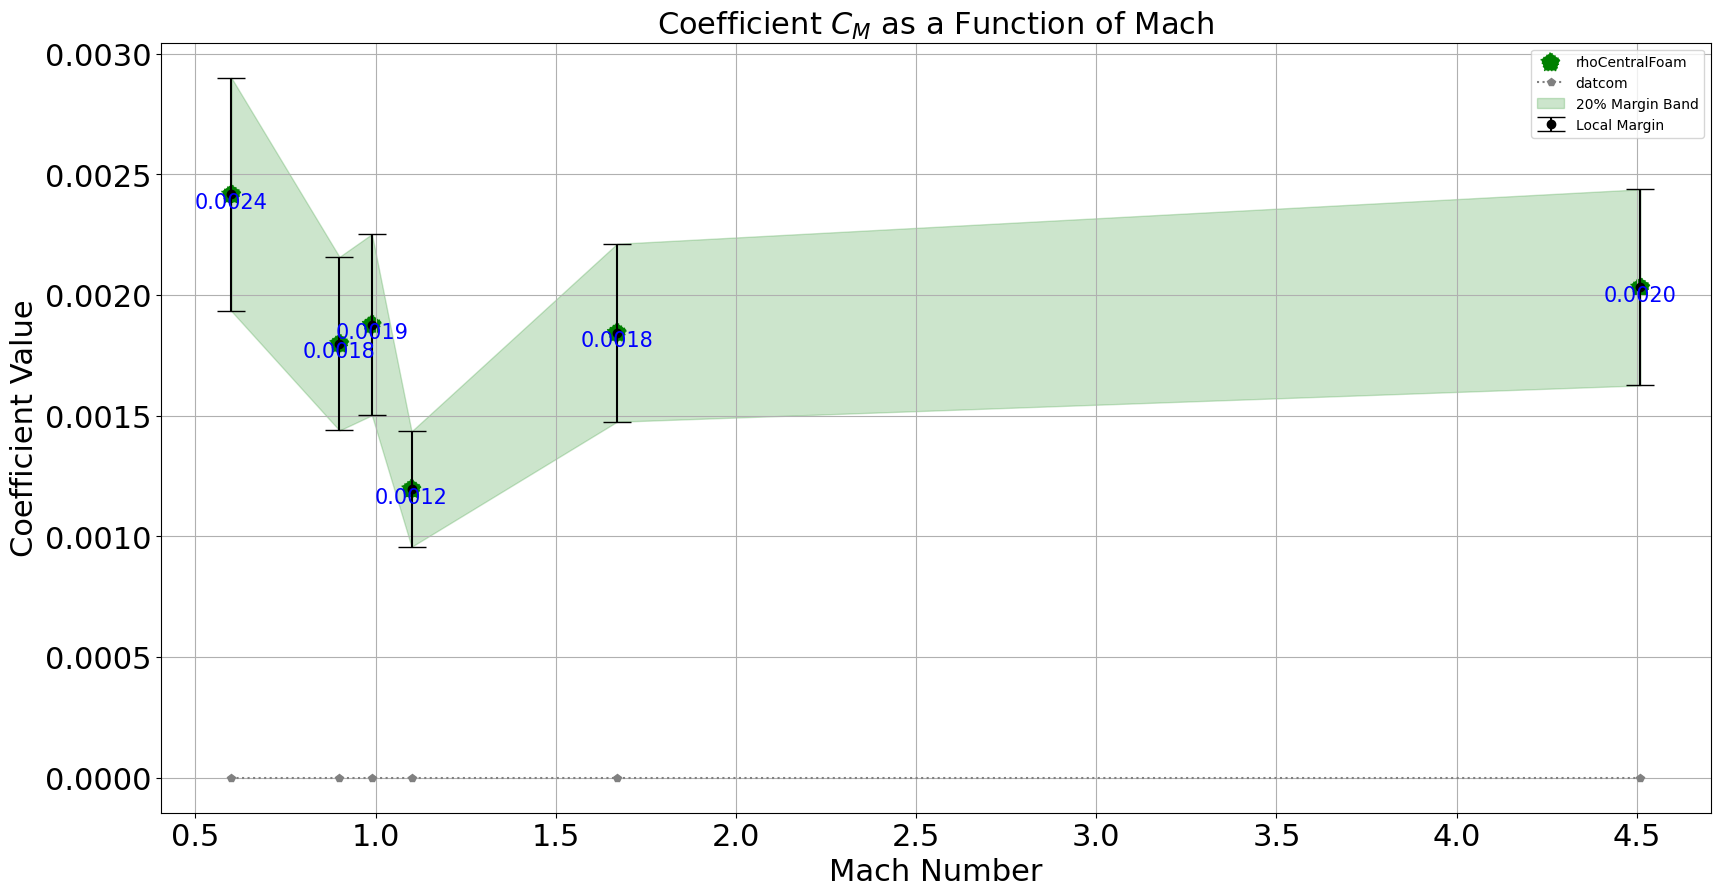

In [150]:
plt.figure(figsize=(20, 10))

plt.scatter(dataset["Mach"], dataset["CmPitch"], label=f'rhoCentralFoam', s=200, marker='p', color='g', linestyle='dotted')

#plt.scatter(rhoCentralFoam_R0["Mach"], rhoCentralFoam_R0["CmPitch"], label='CM rhoCentralFoam R0', s=200, marker='o', color='g', linestyle='solid')
#plt.scatter(rhoCentralFoam_R1["Mach"], rhoCentralFoam_R1["CmPitch"], label='CM rhoCentralFoam R1', s=200, marker='s', color='g', linestyle='dashed')
#plt.scatter(rhoCentralFoam_R2["Mach"], rhoCentralFoam_R2["CmPitch"], label='CM rhoCentralFoam R2', s=200, marker='X', color='g', linestyle='dashdot')
#plt.scatter(rhoCentralFoam_R3["Mach"], rhoCentralFoam_R3["CmPitch"], label=f'$C_M$ rhoCentralFoam $R_3$', s=200, marker='p', color='g', linestyle='dotted')
#plt.scatter(rhoPimpleFoam_R3["Mach"],  rhoPimpleFoam_R3["CmPitch"],  label=f'$C_M$ rhoPimpleFoam $R_3$', s=200, marker='^', color='b', linestyle='dotted')

plt.plot(datcom0["MACH"], datcom0["CM"]+yshift, label='datcom', marker='p', linestyle=':', color='gray')

# Add a 20% margin band
plt.fill_between(dataset["Mach"], lower_margin, upper_margin, color='green', alpha=0.2, label='20% Margin Band')

# Add vertical bars and annotations for each point
plt.errorbar(dataset["Mach"], cm_pitch, yerr=error, fmt='o', color='k', capsize=10, label='Local Margin')

if show_annotations:
    # Annotate each margin value above each point
    for i, margin in enumerate(variable_margins):
        if annotate_bounds:
            # Annotate upper and lower margins near the error bar
            plt.annotate(f"{upper_margin.iloc[i]:.4f}", 
                         (dataset["Mach"].iloc[i], upper_margin.iloc[i]), 
                         textcoords="offset points", xytext=(0, 5),
                         ha='center', fontsize=15, color='red')
            
            plt.annotate(f"{lower_margin.iloc[i]:.4f}", 
                         (dataset["Mach"].iloc[i], lower_margin.iloc[i]), 
                         textcoords="offset points", xytext=(0, -15),
                         ha='center', fontsize=15, color='red')
        if annotate_means:
           # Annotate the actual value at each data point
            plt.annotate(f"{cm_pitch.iloc[i]:.4f}", 
                         (dataset["Mach"].iloc[i], cm_pitch.iloc[i]), 
                         textcoords="offset points", xytext=(0, -10),
                         ha='center', fontsize=15, color='blue')
        
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(fontsize=22)
plt.xlabel('Mach Number')
plt.ylabel('Coefficient Value')
plt.title(r'Coefficient $C_M$ as a Function of Mach', fontsize=22)
plt.legend(fontsize=10)
plt.grid(True)
file_formats = ["pdf", "eps", "png"]
for fmt in file_formats:
    plt.savefig(f"Eris0_CM.{fmt}")
plt.show()
plt.close()

In [151]:
# assume a 20% margin
unmargin = 20 / 100

# Define datasets and properties for each grid level
# NOTE: this should be consistent with the level shown in figures above
datasets = {
    #"R0": rhoCentralFoam_R0,
    "R1": rhoCentralFoam_R1,
    #"R2": rhoCentralFoam_R2
    #"R3": rhoCentralFoam_R3
}

# Initialize an empty DataFrame for the results
results_df = pd.DataFrame()

# Loop through datasets
for grid_level, data in datasets.items():
    if data is not None:  # Check if data exists for the grid level
        for alpha, group_data in data.groupby('AoA'):
            # Calculate upper and lower bounds
            group_data = group_data.copy()  # Avoid modifying original DataFrame
            group_data["Cl upper"]      = group_data["Cl"] * (1 + unmargin)
            group_data["Cl lower"]      = group_data["Cl"] * (1 - unmargin)
            group_data["Cd upper"]      = group_data["Cd"] * (1 + unmargin)
            group_data["Cd lower"]      = group_data["Cd"] * (1 - unmargin)
            group_data["CmPitch upper"] = group_data["CmPitch"] * (1 + unmargin)
            group_data["CmPitch lower"] = group_data["CmPitch"] * (1 - unmargin)
            group_data["Grid Level"]    = grid_level  # Add grid level as a column

            # Append to results DataFrame
            results_df = pd.concat([results_df, group_data], ignore_index=True)

# Display the resulting DataFrame
print(results_df)

# Save to CSV (optional)
#results_df.to_csv("Cl_bounds_results.csv", index=False)
results_df.to_json(orient='records', indent=4, lines=False, path_or_buf='AERO_ERIS_1.1_S123F.json')
print("JSON data has been written to 'AERO_ERIS_1.1_S123F.json'.")

   LastIter        Cd     Cd(f)     Cd(r)            Cl     Cl(f)     Cl(r)  \
0   14656.0  0.302559  0.150589  0.151970 -1.261613e-03  0.001786 -0.003048   
1   15896.0  0.322557  0.161292  0.161265 -4.880946e-04  0.001555 -0.002043   
2   23960.0  0.392739  0.196299  0.196440 -9.675582e-04  0.001394 -0.002361   
3   13885.0  0.437251  0.217474  0.219777 -3.360364e-04  0.001028 -0.001364   
4  100000.0  0.411262  0.204971  0.206291  5.771693e-05  0.001873 -0.001815   
5  300000.0  0.177350  0.088569  0.088781 -8.762325e-07  0.002031 -0.002032   

    CmPitch    CmRoll     CmYaw  ...  Time  GridLevel  Mach  Cl upper  \
0  0.002417 -0.000691  1.552663  ...    34         R1  0.60 -0.001514   
1  0.001799  0.000013  1.526560  ...    43         R1  0.90 -0.000586   
2  0.001877 -0.000070  1.697907  ...    46         R1  0.99 -0.001161   
3  0.001196 -0.001152  1.192385  ...    49         R1  1.10 -0.000403   
4  0.001844 -0.000660 -0.894155  ...    61         R1  1.67  0.000069   
5  0.002

In [178]:
rhoCentralFoam    = result4[result4["Solver"] == "rhoCentralFoam"]
rhoPimpleFoam     = result4[result4["Solver"] == "rhoPimpleFoam"]

rhoCentralFoam_R0 = result4[(result4["Solver"] == "rhoCentralFoam") & (result4["GridLevel"] == "R0")]
rhoPimpleFoam_R0  = result4[(result4["Solver"] == "rhoPimpleFoam")  & (result4["GridLevel"] == "R0")]

rhoCentralFoam_R1 = result4[(result4["Solver"] == "rhoCentralFoam") & (result4["GridLevel"] == "R1")]
rhoPimpleFoam_R1  = result4[(result4["Solver"] == "rhoPimpleFoam")  & (result4["GridLevel"] == "R1")]

rhoCentralFoam_R2 = result4[(result4["Solver"] == "rhoCentralFoam") & (result4["GridLevel"] == "R2")]
rhoPimpleFoam_R2  = result4[(result4["Solver"] == "rhoPimpleFoam")  & (result4["GridLevel"] == "R2")]

rhoCentralFoam_R3 = result4[(result4["Solver"] == "rhoCentralFoam") & (result4["GridLevel"] == "R3")]
rhoPimpleFoam_R3  = result4[(result4["Solver"] == "rhoPimpleFoam")  & (result4["GridLevel"] == "R3")]

In [179]:
# Define the grid level (change this to "R0", "R1", "R2", or "R3" to select the dataset)
# From the figures above we can see the trends across different grid levels
# Typically we would select the finest grid level available, R2 for example
grid_level = "R1" 

# Assuming rhoCentralFoam datasets are dictionaries or DataFrames
# Select the corresponding dataset based on the grid level
# TODO: improve to handle evental rhoPimpleFoam solutions
if grid_level == "R0":
    dataset = rhoCentralFoam_R0
elif grid_level == "R1":
    dataset = rhoCentralFoam_R1
elif grid_level == "R2":
    dataset = rhoCentralFoam_R2
elif grid_level == "R3":
    dataset = rhoCentralFoam_R3
else:
    raise ValueError("Invalid grid level. Please choose from 'R0', 'R1', 'R2', or 'R3'.")
dataset

,LastIter,Cd,Cd(f),Cd(r),Cl,Cl(f),Cl(r),CmPitch,CmRoll,CmYaw,Cs,Cs(f),Cs(r),AoA,Solver,Time,GridLevel,Mach
3,14155.0,0.302447,0.152065,0.150382,-0.187570,-1.143181,0.955611,-1.049396,0.000842,1.905480,-0.422629,1.694166,-2.116795,4.0,rhoCentralFoam,34,R1,0.60
9,16141.0,0.325859,0.164570,0.161289,-0.169483,-1.060768,0.891285,-0.976026,0.001640,1.881269,-0.413680,1.674429,-2.088109,4.0,rhoCentralFoam,43,R1,0.90
15,25268.0,0.392630,0.197841,0.194790,-0.165386,-1.057552,0.892166,-0.974859,0.001525,2.046959,-0.377389,1.858264,-2.235653,4.0,rhoCentralFoam,46,R1,0.99
21,14538.0,0.437724,0.219291,0.218433,-0.160920,-1.062834,0.901914,-0.982374,0.000429,1.551417,-0.277156,1.412840,-1.689995,4.0,rhoCentralFoam,49,R1,1.10
27,100000.0,0.408299,0.204563,0.203736,-0.274131,-1.647058,1.372927,-1.509993,0.000414,-0.673082,0.035327,-0.655419,0.690746,4.0,rhoCentralFoam,61,R1,1.67
33,300000.0,0.176468,0.089512,0.086956,-0.182904,-1.121650,0.938746,-1.030198,0.001278,-1.207645,0.139524,-1.137883,1.277407,4.0,rhoCentralFoam,107,R1,4.51


In [180]:
yshift           = 0.0
cn               = dataset["Cl"]
upper_margin     = cn * 1.20  
lower_margin     = cn * 0.80  
variable_margins = np.full(len(cn), 0.20)
error            = cn * variable_margins 
error            = np.abs(cn * variable_margins) 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


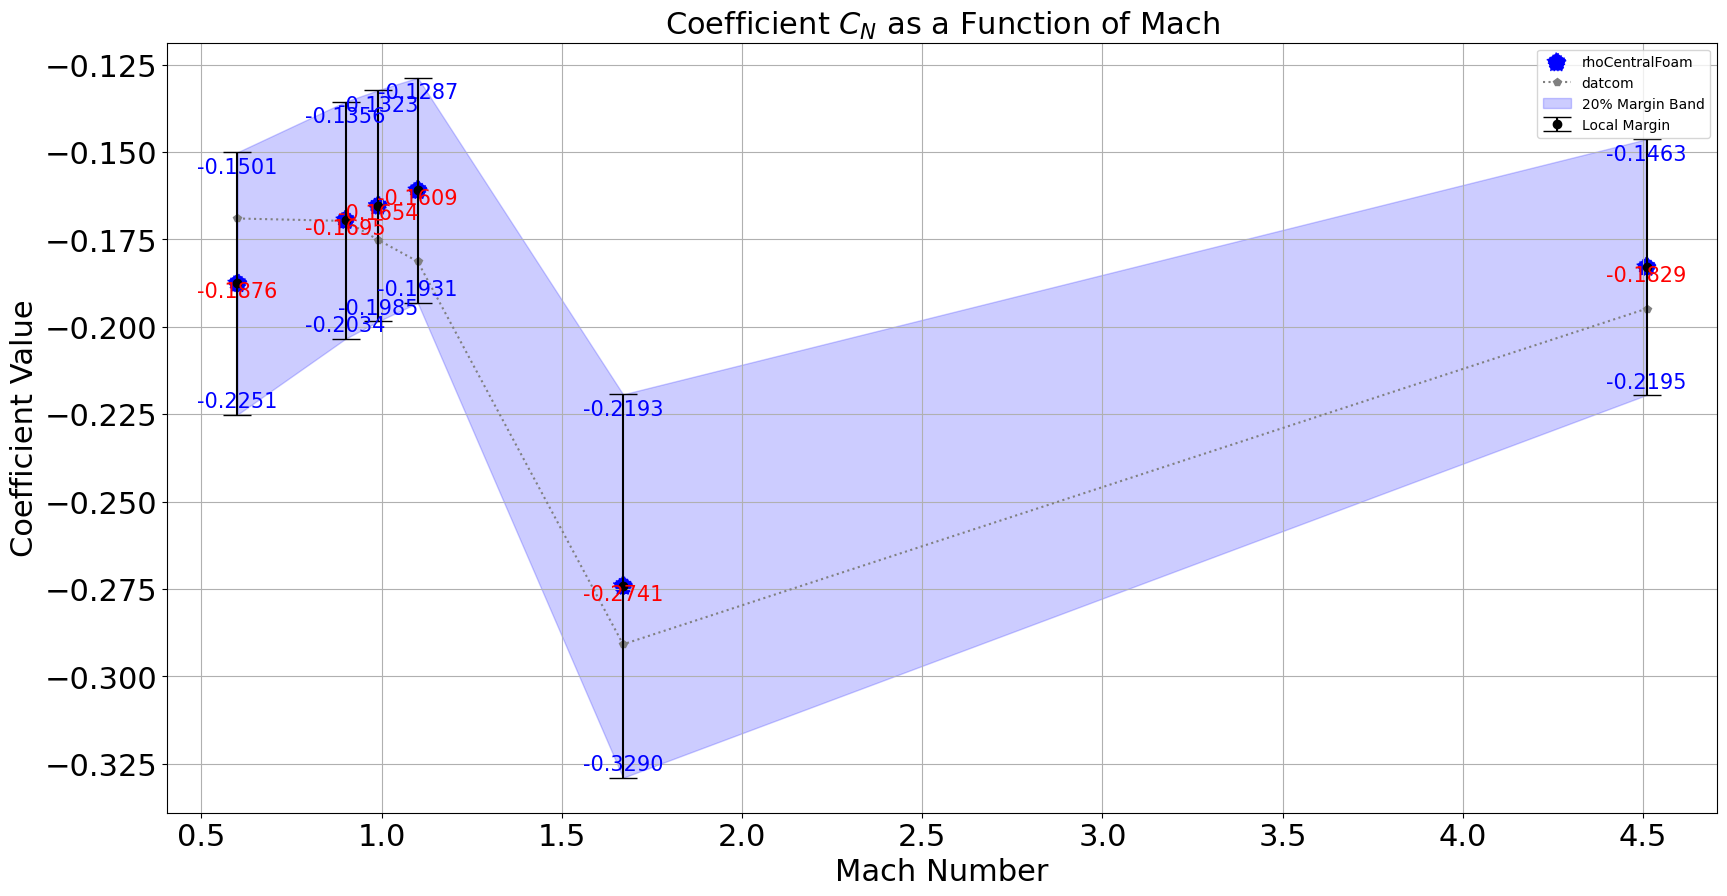

In [181]:
plt.figure(figsize=(20, 10))

plt.scatter(dataset["Mach"], dataset["Cl"], label=f'rhoCentralFoam', s=200, marker='p', color='b', linestyle='dotted')

#plt.scatter(rhoCentralFoam_R0["Mach"], rhoCentralFoam_R0["Cl"], label='CN rhoCentralFoam R0', s=200, marker='o', color='b', linestyle='solid')
#plt.scatter(rhoCentralFoam_R1["Mach"], rhoCentralFoam_R1["Cl"], label='CN rhoCentralFoam R1', s=200, marker='s', color='b', linestyle='dashed')
#plt.scatter(rhoCentralFoam_R2["Mach"], rhoCentralFoam_R2["Cl"], label='CN rhoCentralFoam R2', s=200, marker='X', color='b', linestyle='dashdot')
#plt.scatter(rhoCentralFoam_R3["Mach"], rhoCentralFoam_R3["Cl"], label=f'$C_N$ rhoCentralFoam $R_3$', s=200, marker='p', color='b', linestyle='dotted')
#plt.scatter(rhoPimpleFoam_R3["Mach"],  rhoPimpleFoam_R3["Cl"],  label=f'$C_N$ rhoPimpleFoam $R_3$',  s=200, marker='^', color='b', linestyle='dotted')

plt.plot(datcom4["MACH"], -datcom4["CN"]+yshift, label=f'datcom', marker='p', linestyle=':', color='gray')

# Add a 20% margin band
plt.fill_between(dataset["Mach"], lower_margin, upper_margin, color='blue', alpha=0.2, label='20% Margin Band')

# Add vertical bars and annotations for each point
plt.errorbar(dataset["Mach"], cn, yerr=error, fmt='o', color='k', capsize=10, label='Local Margin')

# Annotate each margin value above each point
for i, margin in enumerate(variable_margins):
    
    # Annotate upper and lower margins near the error bar
    plt.annotate(f"{upper_margin.iloc[i]:.4f}", 
                 (dataset["Mach"].iloc[i], upper_margin.iloc[i]), 
                 textcoords="offset points", xytext=(0, 5),
                 ha='center', fontsize=15, color='blue')
    
    plt.annotate(f"{lower_margin.iloc[i]:.4f}", 
                 (dataset["Mach"].iloc[i], lower_margin.iloc[i]), 
                 textcoords="offset points", xytext=(0, -15),
                 ha='center', fontsize=15, color='blue')

   # Annotate the actual value at each data point
    plt.annotate(f"{cn.iloc[i]:.4f}", 
                 (dataset["Mach"].iloc[i], cn.iloc[i]), 
                 textcoords="offset points", xytext=(0, -10),
                 ha='center', fontsize=15, color='red')

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(fontsize=22)
plt.xlabel('Mach Number')
plt.ylabel('Coefficient Value')
plt.title(r'Coefficient $C_N$ as a Function of Mach', fontsize=22)
plt.legend(fontsize=10)
plt.grid(True)
file_formats = ["pdf", "eps", "png"]
for fmt in file_formats:
    plt.savefig(f"Eris4_CN.{fmt}")
plt.show()
plt.close()

In [182]:
# fine tuning parameters
yshift           = 0.0
cd               = dataset["Cd"]
# here I assume a constant global margin
upper_margin     = cd * 1.20 
lower_margin     = cd * 0.80  
# here I set a variable local margin
#variable_margins = np.array([0.20, 0.15, 0.10, 0.15, 0.15, 0.15])
variable_margins = np.full(len(cd), 0.20)
error            = cd * variable_margins 
error            = np.abs(cd * variable_margins) 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


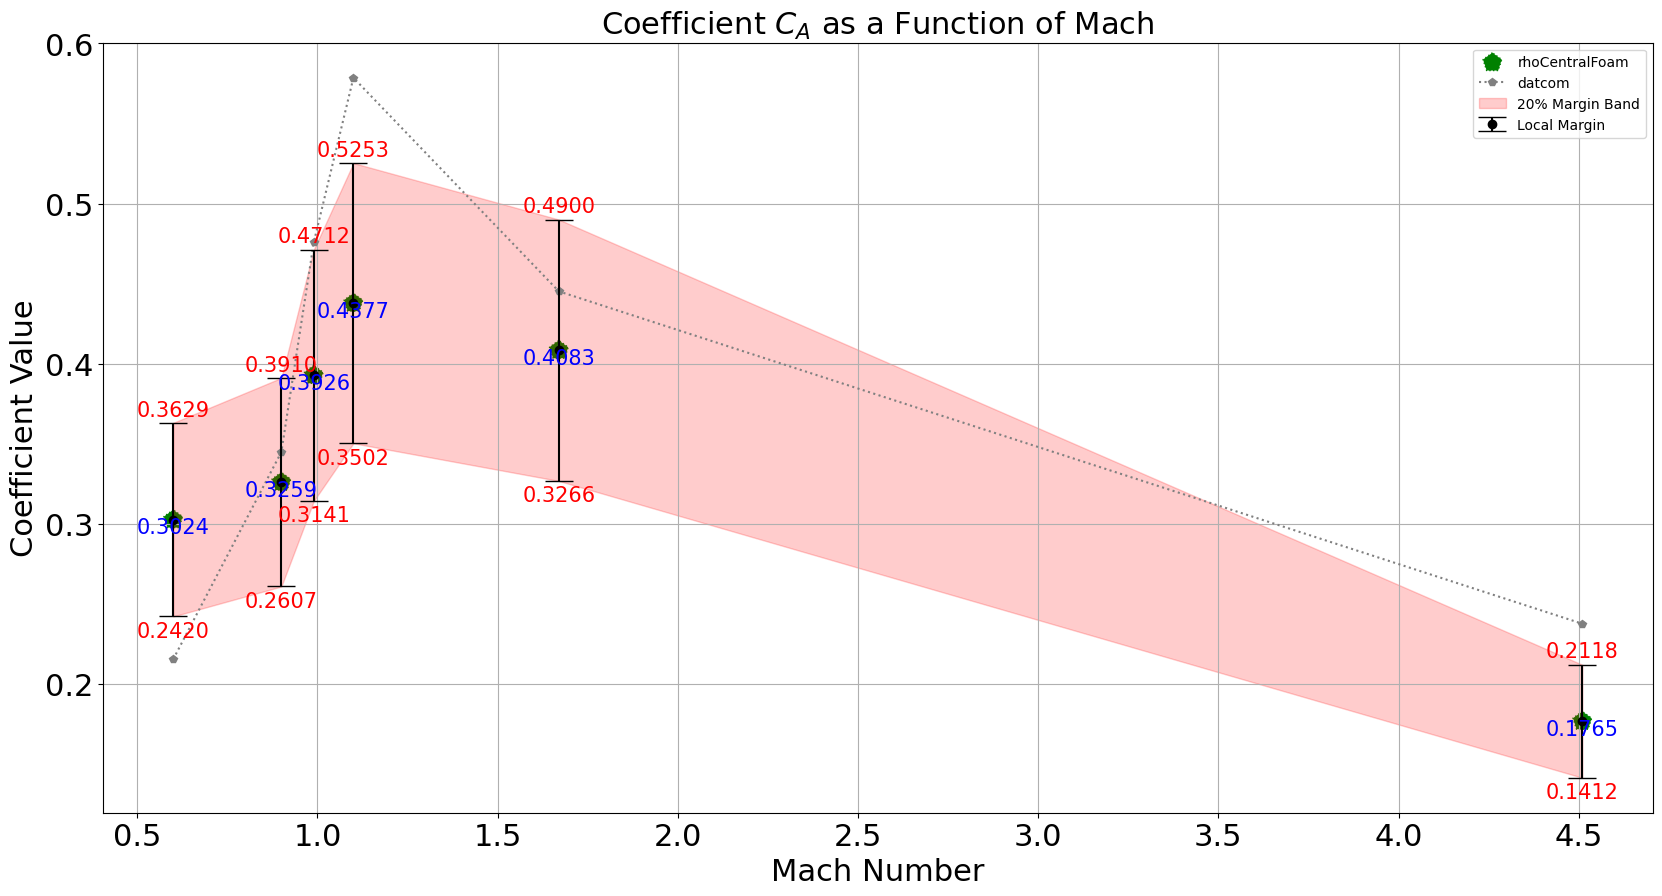

In [183]:
plt.figure(figsize=(20, 10))

plt.scatter(dataset["Mach"], dataset["Cd"], label=f'rhoCentralFoam', s=200, marker='p', color='g', linestyle='dotted')

#plt.scatter(rhoCentralFoam_R0["Mach"], rhoCentralFoam_R0["Cd"], label=r'$C_A$ rhoCentralFoam $R_0$', s=200, marker='o', color='r', linestyle='solid')
#plt.scatter(rhoCentralFoam_R1["Mach"], rhoCentralFoam_R1["Cd"], label=r'$C_A$ rhoCentralFoam $R_1$', s=200, marker='s', color='r', linestyle='dashed')
#plt.scatter(rhoCentralFoam_R2["Mach"], rhoCentralFoam_R2["Cd"], label=r'$C_A$ rhoCentralFoam $R_2$', s=200, marker='X', color='r', linestyle='dashdot')
#plt.scatter(rhoCentralFoam_R3["Mach"], rhoCentralFoam_R3["Cd"], label=r'$C_A$ rhoCentralFoam $R_3$', s=200, marker='p', color='g', linestyle='dotted')

#plt.scatter(rhoPimpleFoam_R3["Mach"],  rhoPimpleFoam_R3["Cd"],  label=r'$C_A$ rhoPimpleFoam $R_3$',  s=200, marker='^', color='b', linestyle='dotted')

plt.plot(datcom4["MACH"], datcom4["CA"]+yshift, label=f'datcom', marker='p', linestyle=':', color='gray')

# Add a 20% margin band
plt.fill_between(dataset["Mach"], lower_margin, upper_margin, color='red', alpha=0.2, label='20% Margin Band')

# Add vertical bars and annotations for each point
plt.errorbar(dataset["Mach"], cd, yerr=error, fmt='o', color='k', capsize=10, label='Local Margin')

# Annotate each margin value above each point
for i, margin in enumerate(variable_margins):
   
    # Annotate upper and lower margins near the error bar
    plt.annotate(f"{upper_margin.iloc[i]:.4f}", 
                 (dataset["Mach"].iloc[i], upper_margin.iloc[i]), 
                 textcoords="offset points", xytext=(0, 5),
                 ha='center', fontsize=15, color='red')
    
    plt.annotate(f"{lower_margin.iloc[i]:.4f}", 
                 (dataset["Mach"].iloc[i], lower_margin.iloc[i]), 
                 textcoords="offset points", xytext=(0, -15),
                 ha='center', fontsize=15, color='red')

   # Annotate the actual value at each data point
    plt.annotate(f"{cd.iloc[i]:.4f}", 
                 (dataset["Mach"].iloc[i], cd.iloc[i]), 
                 textcoords="offset points", xytext=(0, -10),
                 ha='center', fontsize=15, color='blue')

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(fontsize=22)
plt.xlabel('Mach Number')
plt.ylabel('Coefficient Value')
plt.title(r'Coefficient $C_A$ as a Function of Mach', fontsize=22)
plt.legend(fontsize=10)
plt.grid(True)
file_formats = ["pdf", "eps", "png"]
for fmt in file_formats:
    plt.savefig(f"Eris4_CA.{fmt}")
plt.show()
plt.close()

In [184]:
yshift           = 0.0
cm_pitch         = dataset["CmPitch"]
# here I assume a constant global margin
upper_margin     = cm_pitch * 1.20  
lower_margin     = cm_pitch * 0.80 
# here I assume a variable local margin
#variable_margins = np.array([0.20, 0.15, 0.10, 0.15, 0.15, 0.15])
variable_margins = np.full(len(cm_pitch), 0.20)
error            = cm_pitch * variable_margins 
error            = np.abs(cm_pitch * variable_margins)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


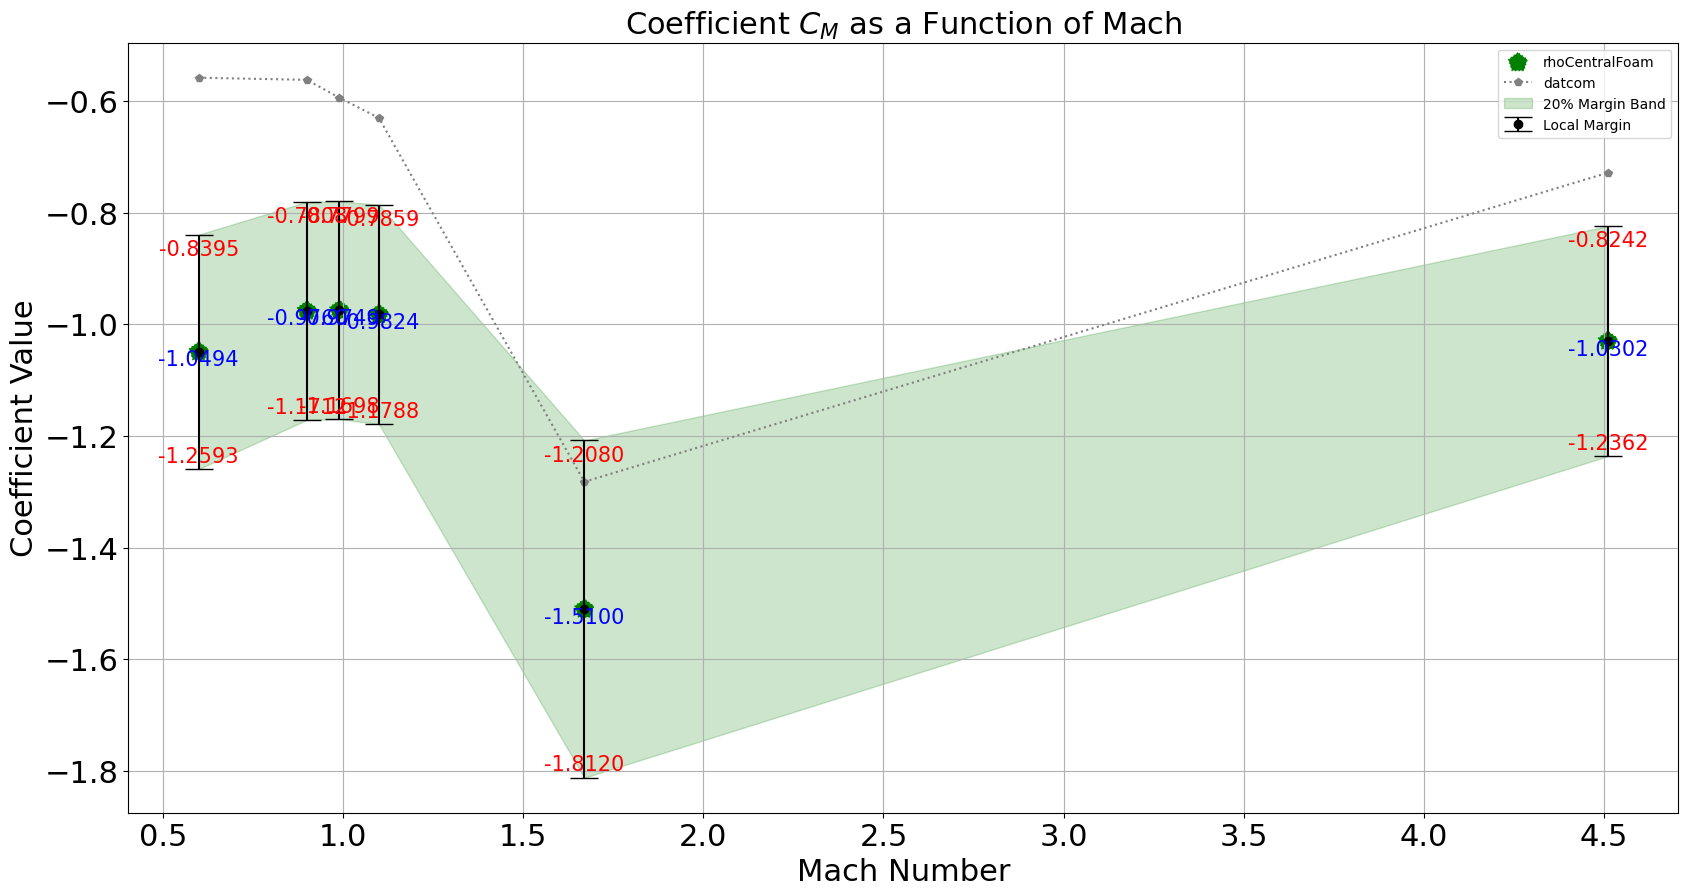

In [185]:
plt.figure(figsize=(20, 10))

plt.scatter(dataset["Mach"], dataset["CmPitch"], label=f'rhoCentralFoam', s=200, marker='p', color='g', linestyle='dotted')

#plt.scatter(rhoCentralFoam_R0["Mach"], rhoCentralFoam_R0["CmPitch"], label='CM rhoCentralFoam R0', s=200, marker='o', color='g', linestyle='solid')
#plt.scatter(rhoCentralFoam_R1["Mach"], rhoCentralFoam_R1["CmPitch"], label='CM rhoCentralFoam R1', s=200, marker='s', color='g', linestyle='dashed')
#plt.scatter(rhoCentralFoam_R2["Mach"], rhoCentralFoam_R2["CmPitch"], label='CM rhoCentralFoam R2', s=200, marker='X', color='g', linestyle='dashdot')
#plt.scatter(rhoCentralFoam_R3["Mach"], rhoCentralFoam_R3["CmPitch"], label=f'$C_M$ rhoCentralFoam $R_3$', s=200, marker='p', color='g', linestyle='dotted')
#plt.scatter(rhoPimpleFoam_R3["Mach"],  rhoPimpleFoam_R3["CmPitch"],  label=f'$C_M$ rhoPimpleFoam $R_3$', s=200, marker='^', color='b', linestyle='dotted')

plt.plot(datcom4["MACH"], datcom4["CM"]+yshift, label=f'datcom', marker='p', linestyle=':', color='gray')

# Add a 20% margin band 
plt.fill_between(dataset["Mach"], lower_margin, upper_margin, color='green', alpha=0.2, label='20% Margin Band')

# Add vertical bars and annotations for each point
plt.errorbar(dataset["Mach"], cm_pitch, yerr=error, fmt='o', color='k', capsize=10, label='Local Margin')

# Annotate each margin value above each point
for i, margin in enumerate(variable_margins):

    # Annotate upper and lower margins near the error bar
    plt.annotate(f"{upper_margin.iloc[i]:.4f}", 
                 (dataset["Mach"].iloc[i], upper_margin.iloc[i]), 
                 textcoords="offset points", xytext=(0, 5),
                 ha='center', fontsize=15, color='red')
    
    plt.annotate(f"{lower_margin.iloc[i]:.4f}", 
                 (dataset["Mach"].iloc[i], lower_margin.iloc[i]), 
                 textcoords="offset points", xytext=(0, -15),
                 ha='center', fontsize=15, color='red')

   # Annotate the actual value at each data point
    plt.annotate(f"{cm_pitch.iloc[i]:.4f}", 
                 (dataset["Mach"].iloc[i], cm_pitch.iloc[i]), 
                 textcoords="offset points", xytext=(0, -10),
                 ha='center', fontsize=15, color='blue')
    
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(fontsize=22)
plt.xlabel('Mach Number')
plt.ylabel('Coefficient Value')
plt.title(r'Coefficient $C_M$ as a Function of Mach', fontsize=22)
plt.legend(fontsize=10)
plt.grid(True)
file_formats = ["pdf", "eps", "png"]
for fmt in file_formats:
    plt.savefig(f"Eris4_CM.{fmt}")
plt.show()
plt.close()

In [186]:
# Convert DataFrame to JSON
#json_data = df.to_json(orient='records')
# json_data = df.to_json(orient='index')
# json_data = df.to_json(orient='columns')
# json_data = df.to_json(orient='split')
# json_data = df.to_json(orient='table')
#result.to_json(orient='records', indent=4, lines=False, path_or_buf='AERO_ERIS_1.1_S123F.json')
#print("JSON data has been written to 'AERO_ERIS_1.1_S123F.json'.")

In [187]:
# Define datasets and properties for each grid level
datasets = {
    #"R0": rhoCentralFoam_R0,
    "R1": rhoCentralFoam_R1,
    #"R": rhoCentralFoam_R2
    #"R3": rhoCentralFoam_R3
}

# Loop through datasets
for grid_level, data in datasets.items():
    if data is not None:  # Check if data exists for the grid level
        for alpha, group_data in data.groupby('AoA'):
            # Calculate upper and lower bounds
            group_data = group_data.copy()  # Avoid modifying original DataFrame
            group_data["Cl upper"]      = group_data["Cl"] * (1 + unmargin)
            group_data["Cl lower"]      = group_data["Cl"] * (1 - unmargin)
            group_data["Cd upper"]      = group_data["Cd"] * (1 + unmargin)
            group_data["Cd lower"]      = group_data["Cd"] * (1 - unmargin)
            group_data["CmPitch upper"] = group_data["CmPitch"] * (1 + unmargin)
            group_data["CmPitch lower"] = group_data["CmPitch"] * (1 - unmargin)
            group_data["Grid Level"]    = grid_level  # Add grid level as a column

            # Append to results DataFrame for alpha = 0 deg
            results_df = pd.concat([results_df, group_data], ignore_index=True)

# Display the resulting DataFrame
print(results_df)

# Save to CSV (optional)
results_df.to_csv("AERO_S123F.csv", index=False)

# Export final AERO database file (.json)
results_df.to_json(orient='records', indent=4, lines=False, path_or_buf='AERO_ERIS_1.1_S123F.json')
print("JSON data has been written to 'AERO_ERIS_1.1_S123F.json'.")

    LastIter        Cd     Cd(f)     Cd(r)            Cl     Cl(f)     Cl(r)  \
0    14656.0  0.302559  0.150589  0.151970 -1.261613e-03  0.001786 -0.003048   
1    15896.0  0.322557  0.161292  0.161265 -4.880946e-04  0.001555 -0.002043   
2    23960.0  0.392739  0.196299  0.196440 -9.675582e-04  0.001394 -0.002361   
3    13885.0  0.437251  0.217474  0.219777 -3.360364e-04  0.001028 -0.001364   
4   100000.0  0.411262  0.204971  0.206291  5.771693e-05  0.001873 -0.001815   
5   300000.0  0.177350  0.088569  0.088781 -8.762325e-07  0.002031 -0.002032   
6    14155.0  0.302447  0.152065  0.150382 -1.875704e-01 -1.143181  0.955611   
7    16141.0  0.325859  0.164570  0.161289 -1.694830e-01 -1.060768  0.891285   
8    25268.0  0.392630  0.197841  0.194790 -1.653857e-01 -1.057552  0.892166   
9    14538.0  0.437724  0.219291  0.218433 -1.609200e-01 -1.062834  0.901914   
10  100000.0  0.408299  0.204563  0.203736 -2.741315e-01 -1.647058  1.372927   
11  300000.0  0.176468  0.089512  0.0869